# Redes neurais convolucionais
Desenvolvimento de um modelo de rede neural convolucional (CNN) para a predição do tempo restante até evento de deslizamento/falha (terremoto).

## Conectando ao Google Drive

In [2]:
## Conectando o notebook com o Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Testando se o notebook acessa o Drive corretamente
!ls 'drive/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'My Drive'  'Shared drives'


In [3]:
#  Mover a pasta compartilhada para algum lugar em seu proprio drive, 
#  para conseguir acessar um atalho para o diretorio a partir daqui.

## Configurar essa variavel de ambiente (path_dados) para cada pessoa
## Meu caminho no drive (alexandre)
%env drv=drive/My Drive
%env proj=Aulas/2019_2/ie301-projeto/projeto

!ls "$drv/$proj/"
!echo "-------"
!ls .

env: drv=drive/My Drive
env: proj=Aulas/2019_2/ie301-projeto/projeto
cnn-regressao-submission.ipynb	imagens  notebooks
dados				modelos  submission-cnn.csv
-------
drive  sample_data


## Importando bibliotecas

In [4]:
## Basic imports
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

## Utils
import timeit
import time
from tqdm import tqdm
import pickle


Populating the interactive namespace from numpy and matplotlib


## Preprocessamento dos arquivos

In [5]:
## Carreando base de treino (downsampled)
!cp "$drv/$proj/dados/train_downsample_100.csv" .
!ls
!du -h *.csv

df_orig = pd.read_csv('train_downsample_100.csv')

## Passos de 300 em 300 (overlap de 80%)
max_index = int((df_orig.shape[0]-1500) / 300)
x_orig = np.zeros([max_index, 1500])
y_orig = np.zeros(max_index)
# y_serie = np.zeros([max_index, 1500])
for line in tqdm(range(max_index)):
    index = line*300
    x_orig[line, :] = df_orig.loc[index:index + 1499,
                             'acoustic_data'].values
    y_orig[line] = df_orig['time_to_failure'][index+1499]
    # y_serie[line, :] = df_orig.loc[index:index + 1499,
    #                          'time_to_failure'].values


## Configuracao de treino: holdout 80/20
holdout_index = int(y_orig.shape[0]*.80)
x_train = x_orig[:holdout_index, :]
y_train = y_orig[:holdout_index]
# y_train_serie = y_serie[:holdout_index, :]


x_valid = x_orig[holdout_index:, :]
y_valid = y_orig[holdout_index:]
# y_valid_serie = y_serie[holdout_index:, :]



drive  sample_data  train_downsample_100.csv
92M	train_downsample_100.csv


100%|██████████| 20966/20966 [00:04<00:00, 4696.69it/s]


### Quantização dos valores de tempo até falha

In [0]:
## Thresholds para quantizar em intervalos balanceados (baseado nos percentis)
thresholds = [
    0,
    np.quantile(y_orig, .10),
    np.quantile(y_orig, .20),
    np.quantile(y_orig, .30),
    np.quantile(y_orig, .40),
    np.quantile(y_orig, .50),
    np.quantile(y_orig, .60),
    np.quantile(y_orig, .70),
    np.quantile(y_orig, .80),
    np.quantile(y_orig, .90)
    ]

In [0]:
thresholds

[0,
 1.0230987892,
 2.0848996629,
 3.1739978565499998,
 4.2618995442,
 5.35164918035,
 6.4414988564,
 7.56399821695,
 8.8902994713,
 10.877347207]

Percentil 0% : 0.0000
Percentil 10% : 1.0231
Percentil 20% : 2.0849
Percentil 30% : 3.1740
Percentil 40% : 4.2619
Percentil 50% : 5.3516
Percentil 60% : 6.4415
Percentil 70% : 7.5640
Percentil 80% : 8.8903
Percentil 90% : 10.8773


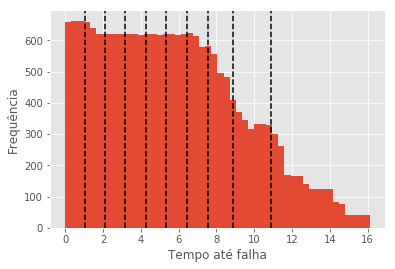

In [0]:
for i in range(len(thresholds)):
    print('Percentil {:.0f}% :'.format(i*0.1*100), '{:.4f}'.format(thresholds[i]))

with plt.style.context('ggplot'):
    plt.hist(y_orig, bins=50);
    for th in thresholds[1:]:
        plt.axvline(x=th, color='k', linestyle='--')
    plt.ylabel('Frequência')
    plt.xlabel('Tempo até falha')
    savefig('histograma-classes.eps', dpi=400, format='eps')
    savefig('histograma-classes.png', dpi=400, format='png')

!cp 'histograma-classes.'* "$drv/$proj/imagens/"

In [7]:
## Quantização dos valores (conversão de numérico para categórico)
from keras.utils import to_categorical

y_quantized = np.zeros(max_index)

for th in range(len(thresholds)-1):
    y_quantized[np.apply_along_axis(lambda x: (x >= thresholds[th]) & (x < thresholds[th+1]),0, y_orig)] = th

# ultima faixa
y_quantized[np.apply_along_axis(lambda x: x >= thresholds[-1], 0, y_orig)] = len(thresholds)-1

y_cate = to_categorical(y_quantized)

y_train_cate = y_cate[:holdout_index]
y_valid_cate = y_cate[holdout_index:]

Using TensorFlow backend.


In [0]:
# ## Gravando as features
with open('dataset-preprocessado.pkl', 'wb') as f:
    dados = {'x_train':x_train, 
             'y_train':y_train, 
             'y_train_cate':y_train_cate, 
             'x_valid':x_valid, 
             'y_valid':y_valid,
             'y_valid_cate':y_valid_cate
             }
    pickle.dump(dados, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

!cp 'dataset-preprocessado.pkl' "$drv/$proj/dados/"


In [0]:
# thresholds = [0.0000, 1.0231, 2.0849, 3.1740, 4.2619,  
#               5.3516, 6.4415, 7.5640, 8.8903, 10.8773]
quantize = []
for x in range(len(thresholds)-1):
    quantize.append((thresholds[x+1]+thresholds[x])/2)
quantize.append(thresholds[-1])

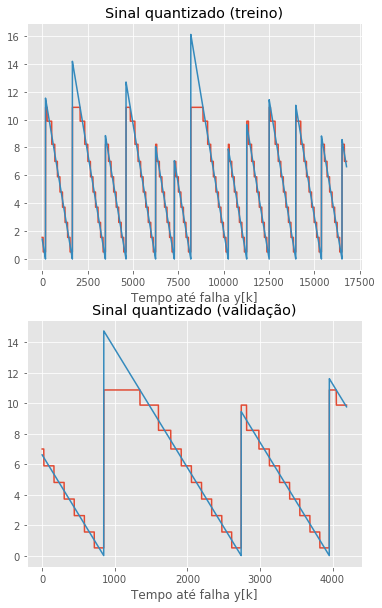

In [0]:
with plt.style.context('ggplot'):
    figsize(6,10)
    subplot(211)
    plt.title('Sinal quantizado (treino)')
    y = np.array([quantize[p] for p in np.argmax(y_train_cate, axis=1)])
    plt.plot(y)
    plt.plot(y_train)
    plt.xlabel('Amostra [k]')
    plt.xlabel('Tempo até falha y[k]')

    subplot(212)
    plt.title('Sinal quantizado (validação)')
    y = np.array([quantize[p] for p in np.argmax(y_valid_cate, axis=1)])
    plt.plot(y)
    plt.plot(y_valid)
    plt.xlabel('Amostra [k]')
    plt.xlabel('Tempo até falha y[k]')

    savefig('sinal-quantizado.eps', dpi=400, format='eps')
    savefig('sinal-quantizado.png', dpi=400, format='png')

!cp 'sinal-quantizado.'* "$drv/$proj/imagens/"

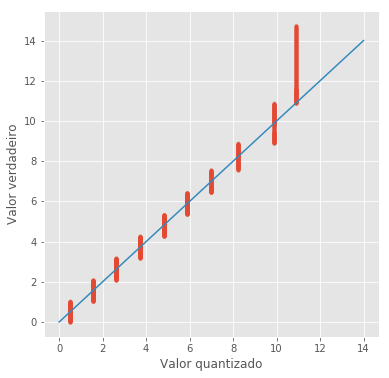

In [10]:
with plt.style.context('ggplot'):
    figsize(6,6)
    y = np.array([quantize[p] for p in np.argmax(y_valid_cate, axis=1)])
    plt.plot(y, y_valid, '.', alpha=.20)
    plt.plot([0, 14], [0, 14])
    plt.xlabel('Valor quantizado')
    plt.ylabel('Valor verdadeiro')
    
    savefig('sinal-quantizado-cruz.eps', dpi=400, format='eps')
    savefig('sinal-quantizado-cruz.png', dpi=400, format='png')

!cp 'sinal-quantizado-cruz.'* "$drv/$proj/imagens/"

In [0]:
# !cp "$drv/$proj/dados/dataset-preprocessado.pkl" .
# with open('dataset-preprocessado.pkl', 'rb') as f:
#     dados = pickle.load(f)
#     f.close()

# x_train = dados['x_train']
# y_train = dados['y_train']
# y_train_cate = dados['y_train_cate']
# x_valid = dados['x_valid']
# y_valid = dados['y_valid']
# y_valid_cate = dados['y_valid_cate']

# del dados